@author ArturoSirvent

Los resultados necesarios son:   

**Problema Inverso**:  Tenemos que obtener la estimación de los parámetros, sin preocuparnos por nada más.  
1º Usando la PINN más básica, hacemos la estimación de varios valores de E, para varios valores de E inicial.     
2º Usando el truco de alpha, hacemos la estimación, lo mismo que antes.  
3º Usando la formulación mixta esa, hacemos lo mismo con lo anterior (con alpha si habia una diferencia sustancial).    
¿4º? Lambde?

**Problema Directo:** 
1º Sin tener que estimar ningún parámetro, sacamos las deformaciones.  
2º Sacando los parámetros sacamos las deformaciones y los valores del parámetros. 
3º Con la formulación mixta. Lo mismo.  

Importante solo imponer los tensores de tensiones conocidos alli donde hay fuerzas.

In [24]:
import os 
BASE_DIR=os.path.abspath("../../")
import sys 
sys.path.append(BASE_DIR)
DATA_DIR="/home/arturo/Documents/programacion_stuff/DeepElasticity/data/001-LinearElasticity"
from src.utils.data import Data
from src.models import PINN  
from src.train import Trainer
import torch 
import matplotlib.pyplot as plt 
import time
from datetime import datetime
import pickle
import numpy as np


# 1. PROBLEMA INVERSO SENCILLO 

## 1.1 Test con un valor


In [7]:
data=Data("MULTIPLE_E_VALUES_NEW",10,E="0.005",base_dir=DATA_DIR)
data.load_data()
train_init_pos_main,train_disp_main,test_init_pos_main,test_disp_main,position_selected_stresses,return_stress,return_colloc_points=data.prepare_pytorch_data()


In [8]:
init_values={"nu":.4,"E":0.1}
pinn=PINN([3,80,80,80,80,80,3],use_of_alpha=False,init_values=init_values,loss_weights_init={"data":1e1,"PDE":1e5,"BC":1e6})
step_dict = {
    "step_1": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-3), 
               "epochs": 1070}
    }

In [9]:
trainer=Trainer(step_dict)

In [10]:
trainer.train(pinn,data)

Epoch:  0 loss:  65.6131820678711
Epoch:  1 loss:  48.11103057861328
Epoch:  2 loss:  45.809844970703125
Epoch:  3 loss:  45.610652923583984
Epoch:  4 loss:  44.23525619506836
Epoch:  5 loss:  42.38081359863281
Epoch:  6 loss:  40.61784744262695
Epoch:  7 loss:  39.158203125
Epoch:  8 loss:  38.075782775878906
Epoch:  9 loss:  37.314476013183594
Epoch:  10 loss:  36.73326110839844
Epoch:  11 loss:  36.21462631225586
Epoch:  12 loss:  35.71390151977539
Epoch:  13 loss:  35.23286437988281
Epoch:  14 loss:  34.78144836425781
Epoch:  15 loss:  34.36521911621094
Epoch:  16 loss:  33.988826751708984
Epoch:  17 loss:  33.65835952758789
Epoch:  18 loss:  33.378597259521484
Epoch:  19 loss:  33.14970016479492
Epoch:  20 loss:  32.9665412902832
Epoch:  21 loss:  32.820777893066406
Epoch:  22 loss:  32.70360565185547
Epoch:  23 loss:  32.607696533203125
Epoch:  24 loss:  32.52783966064453
Epoch:  25 loss:  32.46046829223633
Epoch:  26 loss:  32.40287399291992
Epoch:  27 loss:  32.35255432128906
E

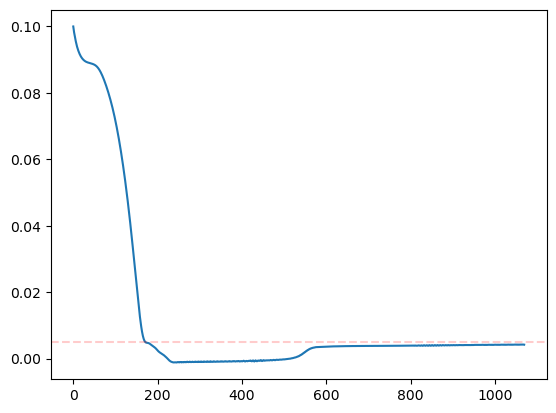

In [13]:
plt.plot(pinn.params_history["E"])
plt.axhline(y=0.005,linestyle="--",alpha=0.2,color="red")

In [19]:
from pympler import asizeof
asizeof.asizeof(pinn)/1e+6


0.204712

## 1.2 Caso para todos los valores de E disponibles:   

In [6]:

EPOCHS1=200
EPOCHS2=1600
EPOCHS3=1200
fecha_actual_str = datetime.now().strftime("%Y-%m-%d")

RESULTADOS_DIR=os.path.join(BASE_DIR,"informes/endYear2023/resultados")

DAILY_RESULTADOS_DIR=os.path.join(RESULTADOS_DIR,fecha_actual_str)
os.makedirs(DAILY_RESULTADOS_DIR,exist_ok=True)

E_options=["0.020","0.040","0.050","0.060","0.005","0.009"]#"0.020",
E_inits=[0.01,0.07,0.1,0.3,1]
loss_weights_init={"data":1e1,"PDE":1e5,"BC":1e6}
pinn_arch=[3,80,80,80,80,80,3]

historial_E_train={}
for i,E_real_str in enumerate(E_options):
    print(f"E_real: {E_real_str}")
    data=Data("MULTIPLE_E_VALUES",10,E=E_real_str,base_dir=DATA_DIR)
    data.load_data()
    train_init_pos_main,train_disp_main,test_init_pos_main,test_disp_main,position_selected_stresses,return_stress,return_colloc_points=data.prepare_pytorch_data()
    dict_E_inits={}
    for E_init in E_inits:
        print(f"\t E_init: {E_init}")

        time_init=time.time()
        init_values={"nu":.4,"E":E_init}
        pinn=PINN(pinn_arch,use_of_alpha=False,init_values=init_values,loss_weights_init=loss_weights_init)
        step_dict = {
            "step_1": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-2), 
                    "epochs": EPOCHS1},
            "step_2": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-3), 
                    "epochs": EPOCHS2},
            "step_3": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-4), 
                    "epochs": EPOCHS3}
            }
        trainer=Trainer(step_dict)
        trainer.train(pinn,data)
        time_fin=time.time()
        dict_E_inits[str(E_init)]={"model_object":pinn,"time":time_fin-time_init,"E_real":float(E_real_str)}
    historial_E_train[E_real_str]=dict_E_inits
    del dict_E_inits
    #guardamos 
    fecha_hora_actual_str = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    archivo_pickle=os.path.join(DAILY_RESULTADOS_DIR, f'{fecha_hora_actual_str}.pkl')
    with open(archivo_pickle, 'wb') as archivo:
        pickle.dump(historial_E_train, archivo)



E_real: 0.020
	 E_init: 0.01
step_1
Epoch:  1 loss:  13.744867324829102
Epoch:  2 loss:  19.15102767944336
Epoch:  3 loss:  15.887118339538574
Epoch:  4 loss:  11.558156967163086
Epoch:  5 loss:  10.213290214538574
Epoch:  6 loss:  12.023263931274414
Epoch:  7 loss:  10.702495574951172
Epoch:  8 loss:  9.497615814208984
Epoch:  9 loss:  9.358161926269531
Epoch:  10 loss:  9.552430152893066
Epoch:  11 loss:  9.432206153869629
Epoch:  12 loss:  9.251237869262695
Epoch:  13 loss:  8.375667572021484
Epoch:  14 loss:  9.001489639282227
Epoch:  15 loss:  8.562738418579102
Epoch:  16 loss:  8.713648796081543
Epoch:  17 loss:  8.448917388916016
Epoch:  18 loss:  8.16269302368164
Epoch:  19 loss:  8.410877227783203
Epoch:  20 loss:  8.197433471679688
Epoch:  21 loss:  8.095466613769531
Epoch:  22 loss:  8.084867477416992
Epoch:  23 loss:  7.921924114227295
Epoch:  24 loss:  7.896690368652344
Epoch:  25 loss:  7.916803359985352
Epoch:  26 loss:  7.696495056152344
Epoch:  27 loss:  7.808659553527

In [7]:
historial_E_train

{'0.020': {'0.01': {'model_object': PINN(
     (activation): Tanh()
     (linears): ModuleList(
       (0): Linear(in_features=3, out_features=80, bias=True)
       (1-4): 4 x Linear(in_features=80, out_features=80, bias=True)
       (5): Linear(in_features=80, out_features=3, bias=True)
     )
     (loss_function): MSELoss()
   ),
   'time': 710.0814728736877,
   'E_real': 0.02},
  '0.07': {'model_object': PINN(
     (activation): Tanh()
     (linears): ModuleList(
       (0): Linear(in_features=3, out_features=80, bias=True)
       (1-4): 4 x Linear(in_features=80, out_features=80, bias=True)
       (5): Linear(in_features=80, out_features=3, bias=True)
     )
     (loss_function): MSELoss()
   ),
   'time': 717.1610901355743,
   'E_real': 0.02},
  '0.1': {'model_object': PINN(
     (activation): Tanh()
     (linears): ModuleList(
       (0): Linear(in_features=3, out_features=80, bias=True)
       (1-4): 4 x Linear(in_features=80, out_features=80, bias=True)
       (5): Linear(in_fe

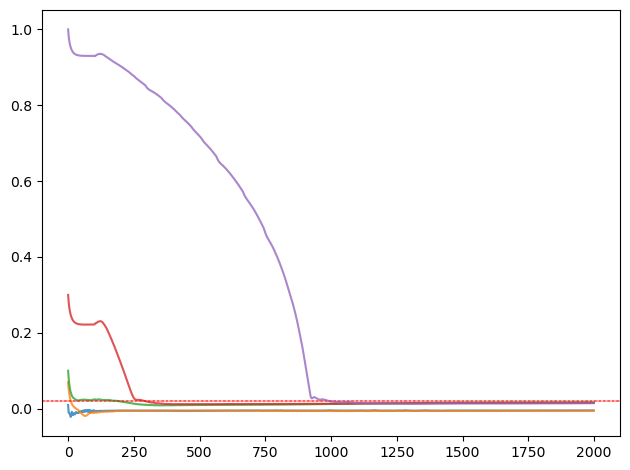

In [16]:
plt.style.use('default')


fig,ax=plt.subplots()

x1, x2, y1, y2 = -1, 1400, 0, 0.05  # subregion of the original image
# axins = ax.inset_axes(
# [0.3, 0.3, 0.67, 0.67],
# xlim=(x1, x2), ylim=(y1, y2), )

E_real_str="0.020"
dict_E_real=historial_E_train[E_real_str]

for E_init in dict_E_real.keys():
    init_dict=dict_E_real[E_init]
    valores_E_train=init_dict["model_object"].params_history["E"]
    ax.plot(valores_E_train,alpha=0.79,label=f"Init E value: {i}")
    ax.axhline(init_dict["E_real"],linestyle="-.",alpha=0.8,color="red",linewidth=0.3)
    #axins.plot(valores_E_train)
    #axins.axhline(init_dict["E_real"],linestyle="-.",alpha=0.7,color="red",linewidth=1)

#plt.title(f"E_true:{E_real_str}")
#ax.indicate_inset_zoom(axins, edgecolor="black")
plt.tight_layout()


In [ ]:
for E_init in dict_E_real.keys():
    init_dict=dict_E_real[E_init]
    valores_E_train=init_dict["model_object"].params_history["E"]
    print()

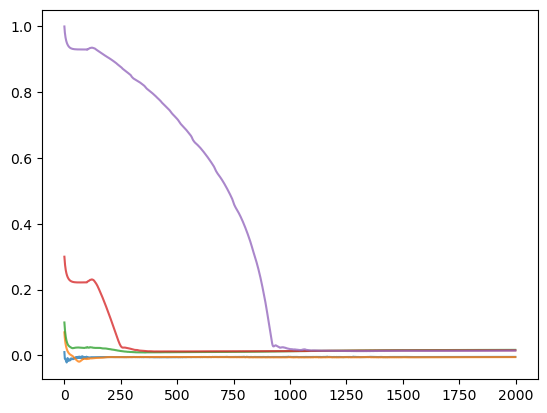

In [10]:
plt.style.use('default')


fig,ax=plt.subplots()

E_real_str="0.020"
dict_E_real=historial_E_train[E_real_str]

for E_init in dict_E_real.keys():
    init_dict=dict_E_real[E_init]
    valores_E_train=init_dict["model_object"].params_history["E"]
    ax.plot(valores_E_train,alpha=0.79,label=f"Init E value: {i}")

### Revision resultados 

In [3]:
with open("/home/arturosf/Documentos/repos/DeepElasticity/informes/endYear2023/resultados/2024-01-14/2024-01-15T14-05-46.pkl","br") as fil:
    data=pickle.load(fil)

/home/arturosf/miniconda3/envs/pinns/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [8]:
data["0.005"]

{'0.01': {'model_object': PINN(
    (activation): Tanh()
    (linears): ModuleList(
      (0): Linear(in_features=3, out_features=80, bias=True)
      (1-4): 4 x Linear(in_features=80, out_features=80, bias=True)
      (5): Linear(in_features=80, out_features=3, bias=True)
    )
    (loss_function): MSELoss()
  ),
  'time': 1835.9359374046326,
  'E_real': 0.005},
 '0.07': {'model_object': PINN(
    (activation): Tanh()
    (linears): ModuleList(
      (0): Linear(in_features=3, out_features=80, bias=True)
      (1-4): 4 x Linear(in_features=80, out_features=80, bias=True)
      (5): Linear(in_features=80, out_features=3, bias=True)
    )
    (loss_function): MSELoss()
  ),
  'time': 1847.0152986049652,
  'E_real': 0.005},
 '0.1': {'model_object': PINN(
    (activation): Tanh()
    (linears): ModuleList(
      (0): Linear(in_features=3, out_features=80, bias=True)
      (1-4): 4 x Linear(in_features=80, out_features=80, bias=True)
      (5): Linear(in_features=80, out_features=3, bias=T

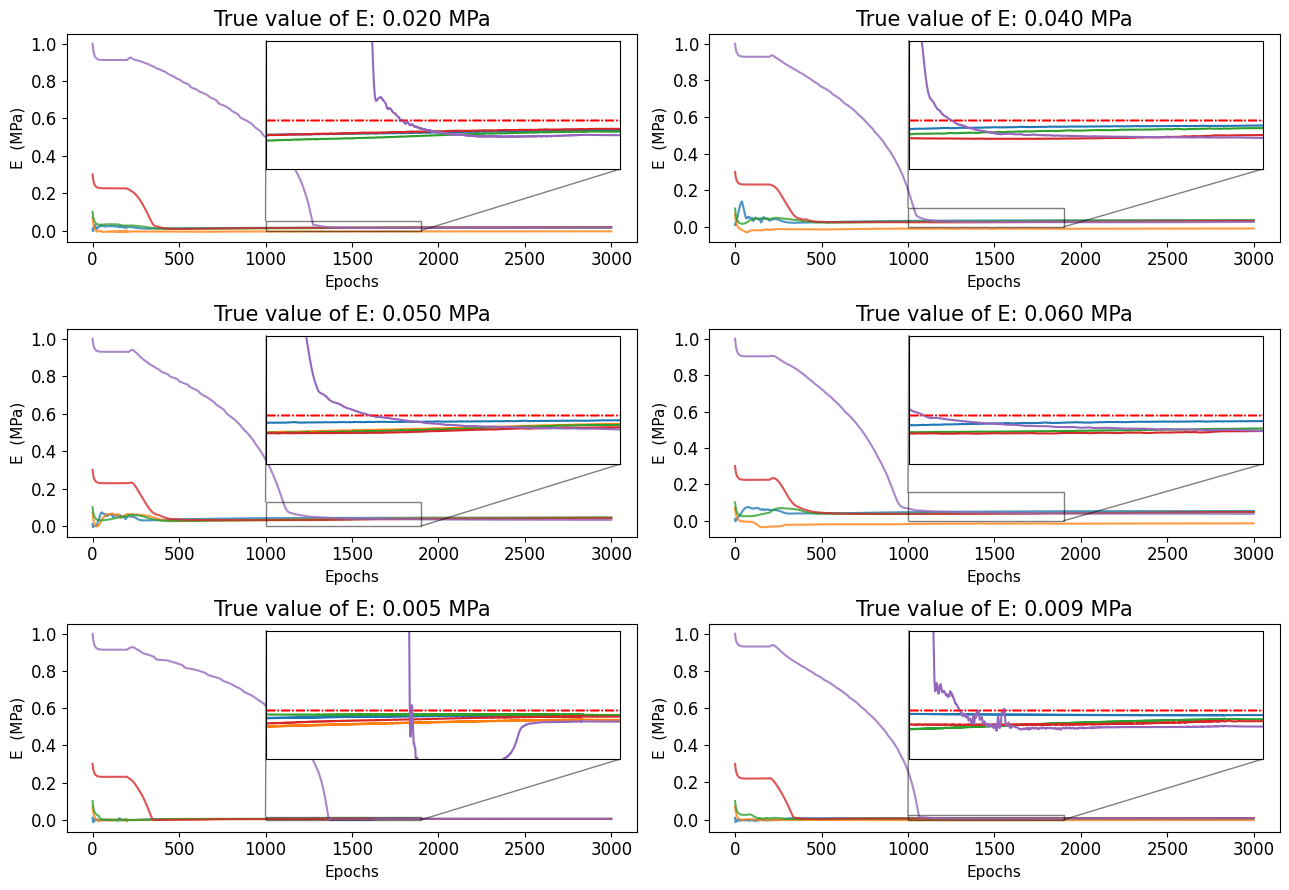

In [69]:
plt.style.use('default')
fig=plt.figure(figsize=(13,9))

for i,E_real_str in enumerate(data.keys()):

    plt.subplot(3,2,i+1)
    dict_E_real=data[E_real_str]

    ax=plt.gca()
    x1, x2, y1, y2 = 1000, 1900, 0, float(E_real_str)*2.6  # subregion of the original image
    axins = ax.inset_axes(
    [0.35, 0.35, 0.62, 0.62],
    xlim=(x1, x2), ylim=(y1, y2), )

    for E_init in dict_E_real.keys():
        init_dict=dict_E_real[E_init]
        valores_E_train=init_dict["model_object"].params_history["E"]
        plt.plot(valores_E_train,alpha=0.79,label=f"Init E value: {i} MPa")
        axins.plot(valores_E_train)
        axins.set_xticks([])
        axins.set_yticks([])
        axins.axhline(float(E_real_str),linestyle="-.",alpha=0.7,color="red",linewidth=1)
    ax.indicate_inset_zoom(axins, edgecolor="black")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Epochs",fontsize=11)
    plt.ylabel("E  (MPa)",fontsize=11)
    plt.title(f"True value of E: {E_real_str} MPa",fontsize=15)
plt.tight_layout()
plt.savefig("../../informes/endYear2023/resultados/2024-01-14(E_SIMPLE)/E_train.png")

Representemos los valores para las últimas 200 épocas, y el valor real.

In [65]:
dict_errores={}
for i, E_real_str in enumerate(data.keys()):
    dict_E_real = data[E_real_str]
    dict_errores_aux={}
    for j, E_init in enumerate(dict_E_real.keys()):
        init_dict = dict_E_real[E_init]
        valores_E_train = np.array(init_dict["model_object"].params_history["E"][-200:])
        true_value = float(E_real_str)
        errores_aux=abs(valores_E_train-true_value)/true_value
        dict_errores_aux[E_init]=(np.round(np.mean(errores_aux)*100,2),np.round(np.std(errores_aux)*100,2))
        
    dict_errores[E_real_str]=dict_errores_aux



In [66]:
for i in dict_errores.keys():
    print(i)
    print(dict_errores[i])

0.020
{'0.01': (17.03, 0.22), '0.07': (121.86, 0.07), '0.1': (20.69, 0.25), '0.3': (12.75, 0.34), '1': (16.71, 0.41)}
0.040
{'0.01': (10.33, 0.1), '0.07': (122.78, 0.16), '0.1': (11.44, 0.3), '0.3': (20.66, 0.34), '1': (33.99, 0.66)}
0.050
{'0.01': (8.95, 0.13), '0.07': (11.45, 0.23), '0.1': (12.42, 0.25), '0.3': (18.91, 0.41), '1': (34.97, 0.14)}
0.060
{'0.01': (10.98, 0.15), '0.07': (123.86, 0.12), '0.1': (21.52, 0.31), '0.3': (20.01, 0.44), '1': (36.28, 0.02)}
0.005
{'0.01': (10.73, 0.05), '0.07': (17.51, 0.22), '0.1': (11.46, 0.06), '0.3': (11.84, 0.12), '1': (14.26, 0.26)}
0.009
{'0.01': (10.25, 0.08), '0.07': (123.71, 0.21), '0.1': (16.53, 0.07), '0.3': (15.25, 0.3), '1': (20.94, 0.65)}


## 1.3 Lo mismo pero haciendo estimaciones de E con alpha 

In [3]:
import os 
BASE_DIR=os.path.abspath("../../")
import sys 
sys.path.append(BASE_DIR)
DATA_DIR=os.path.join(BASE_DIR,"data/001-LinearElasticity")
from src.utils.data import Data
from src.models import PINN  
from src.train import Trainer
import torch 
import time
from datetime import datetime
import pickle



EPOCHS1=2#200
EPOCHS2=2#1600
EPOCHS3=2#1200
fecha_actual_str = datetime.now().strftime("%Y-%m-%d")

In [4]:
RESULTADOS_DIR=os.path.join(BASE_DIR,"informes/endYear2023/resultados")

DAILY_RESULTADOS_DIR=os.path.join(RESULTADOS_DIR,fecha_actual_str)
os.makedirs(DAILY_RESULTADOS_DIR,exist_ok=True)

In [5]:


RESULTADOS_DIR=os.path.join(BASE_DIR,"informes/endYear2023/resultados")

DAILY_RESULTADOS_DIR=os.path.join(RESULTADOS_DIR,fecha_actual_str)
os.makedirs(DAILY_RESULTADOS_DIR,exist_ok=True)

E_options=["0.020","0.040","0.050","0.060","0.005","0.009","0.032"]
E_refs=[0.001,0.01,0.1]
loss_weights_init={"data":1e1,"PDE":1e5,"BC":1e6}
pinn_arch=[3,80,80,80,80,80,3]

historial_E_train={}
for i,E_real_str in enumerate(E_options):
    print(f"E_real: {E_real_str}")
    data=Data("MULTIPLE_E_VALUES",10,E=E_real_str,base_dir=DATA_DIR)
    data.load_data()
    train_init_pos_main,train_disp_main,test_init_pos_main,test_disp_main,position_selected_stresses,return_stress,return_colloc_points=data.prepare_pytorch_data()
    dict_E_refs={}
    for E_ref in E_refs:
        print(f"\t E_ref: {E_ref}")

        time_init=time.time()
        init_values={"nu":.4,"alpha":1,"E_ref":E_ref}
        pinn=PINN(pinn_arch,use_of_alpha=True,init_values=init_values,loss_weights_init=loss_weights_init)
        step_dict = {
            "step_1": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-2), 
                    "epochs": EPOCHS1},
            "step_2": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-3), 
                    "epochs": EPOCHS2},
            "step_3": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-4), 
                    "epochs": EPOCHS3}
            }
        trainer=Trainer(step_dict)
        trainer.train(pinn,data)
        time_fin=time.time()
        dict_E_refs[str(E_ref)]={"model_object":pinn,"time":time_fin-time_init,"E_real":float(E_real_str)}
    historial_E_train[E_real_str]=dict_E_refs
    del dict_E_refs
    #guardamos 
    fecha_hora_actual_str = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    archivo_pickle=os.path.join(DAILY_RESULTADOS_DIR, f'{fecha_hora_actual_str}.pkl')
    with open(archivo_pickle, 'wb') as archivo:
        pickle.dump(historial_E_train, archivo)



E_real: 0.020


/home/arturosf/miniconda3/envs/pinns/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/arturosf/Documentos/repos/DeepElasticity/src/models.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)


	 E_ref: 0.001
step_1
Epoch:  1 loss:  12.333227157592773
Epoch:  2 loss:  21.064891815185547
step_2
Epoch:  3 loss:  13.563763618469238
Epoch:  4 loss:  10.930537223815918
step_3
Epoch:  5 loss:  9.66545295715332
Epoch:  6 loss:  9.581274032592773
	 E_ref: 0.01
step_1


/home/arturosf/Documentos/repos/DeepElasticity/src/models.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)


Epoch:  1 loss:  14.758272171020508
Epoch:  2 loss:  17.044496536254883
step_2
Epoch:  3 loss:  11.695989608764648
Epoch:  4 loss:  9.313615798950195
step_3
Epoch:  5 loss:  8.676597595214844
Epoch:  6 loss:  8.589065551757812
	 E_ref: 0.1
step_1


/home/arturosf/Documentos/repos/DeepElasticity/src/models.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)


Epoch:  1 loss:  52.713348388671875
Epoch:  2 loss:  422.33782958984375
step_2
Epoch:  3 loss:  30.365924835205078
Epoch:  4 loss:  18.004901885986328
step_3
Epoch:  5 loss:  14.906002044677734
Epoch:  6 loss:  14.588930130004883
E_real: 0.040
	 E_ref: 0.001
step_1


/home/arturosf/Documentos/repos/DeepElasticity/src/models.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)


Epoch:  1 loss:  7.601078987121582
Epoch:  2 loss:  20.94481658935547
step_2
Epoch:  3 loss:  10.12850570678711
Epoch:  4 loss:  7.359938144683838
step_3
Epoch:  5 loss:  6.084961891174316
Epoch:  6 loss:  5.922915458679199
	 E_ref: 0.01
step_1


/home/arturosf/Documentos/repos/DeepElasticity/src/models.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)


Epoch:  1 loss:  9.021380424499512
Epoch:  2 loss:  23.416030883789062
step_2
Epoch:  3 loss:  7.297616004943848
Epoch:  4 loss:  6.203076362609863
step_3
Epoch:  5 loss:  6.509261131286621
Epoch:  6 loss:  6.297170639038086
	 E_ref: 0.1
step_1


/home/arturosf/Documentos/repos/DeepElasticity/src/models.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)


Epoch:  1 loss:  71.43629455566406
Epoch:  2 loss:  241.78964233398438
step_2
Epoch:  3 loss:  25.572723388671875
Epoch:  4 loss:  12.444282531738281
step_3
Epoch:  5 loss:  8.574105262756348
Epoch:  6 loss:  8.280513763427734
E_real: 0.050
	 E_ref: 0.001
step_1


/home/arturosf/Documentos/repos/DeepElasticity/src/models.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)


Epoch:  1 loss:  10.13957691192627
Epoch:  2 loss:  26.293176651000977
step_2
Epoch:  3 loss:  9.857906341552734
Epoch:  4 loss:  7.101266384124756
step_3
Epoch:  5 loss:  5.896236419677734
Epoch:  6 loss:  5.651853561401367
	 E_ref: 0.01
step_1


/home/arturosf/Documentos/repos/DeepElasticity/src/models.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)


Epoch:  1 loss:  8.440277099609375
Epoch:  2 loss:  26.38153648376465
step_2
Epoch:  3 loss:  9.184213638305664
Epoch:  4 loss:  5.288504123687744
step_3
Epoch:  5 loss:  5.933277130126953
Epoch:  6 loss:  5.641846656799316
	 E_ref: 0.1
step_1


/home/arturosf/Documentos/repos/DeepElasticity/src/models.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)


Epoch:  1 loss:  27.32174301147461
Epoch:  2 loss:  552.377197265625
step_2
Epoch:  3 loss:  22.143108367919922
Epoch:  4 loss:  12.846953392028809
step_3
Epoch:  5 loss:  9.439582824707031
Epoch:  6 loss:  9.001169204711914
E_real: 0.060
	 E_ref: 0.001
step_1


/home/arturosf/Documentos/repos/DeepElasticity/src/models.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)


Epoch:  1 loss:  8.684765815734863
Epoch:  2 loss:  18.658084869384766
step_2
Epoch:  3 loss:  14.324357032775879
Epoch:  4 loss:  9.687389373779297
step_3
Epoch:  5 loss:  6.875667572021484
Epoch:  6 loss:  6.52416467666626
	 E_ref: 0.01
step_1


/home/arturosf/Documentos/repos/DeepElasticity/src/models.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)


KeyboardInterrupt: 

## 1.4 Lo mismo pero dejando los pesos de cada término como un parametro de la red 

# 2 Estimación de desplazamientos u

## 2.1 Estimación de desplazamientos conocidos los parametros

In [1]:
import os 
BASE_DIR=os.path.abspath("../../")
import sys 
sys.path.append(BASE_DIR)
DATA_DIR=os.path.join(BASE_DIR,"data/001-LinearElasticity")
from src.utils.data import Data
from src.models import PINN  
from src.train import Trainer
import torch 
import time
from datetime import datetime
import pickle

EPOCHS1=2#200
EPOCHS2=2#1600
EPOCHS3=2#1200
fecha_actual_str = datetime.now().strftime("%Y-%m-%d")
RESULTADOS_DIR=os.path.join(BASE_DIR,"informes/endYear2023/resultados_desplazamientos")

In [2]:
DAILY_RESULTADOS_DIR=os.path.join(RESULTADOS_DIR,fecha_actual_str)
os.makedirs(DAILY_RESULTADOS_DIR,exist_ok=True)


E_options=["0.020","0.040","0.050","0.060","0.005","0.009","0.032"]
loss_weights_init={"data":1e1,"PDE":1e5,"BC":1e6}
pinn_arch=[3,80,80,80,80,80,3]

historial_E_train={}
for i,E_real_str in enumerate(E_options):
    print(f"E_real: {E_real_str}")
    data=Data("MULTIPLE_E_VALUES",10,E=E_real_str,base_dir=DATA_DIR)
    data.load_data()
    train_init_pos_main,train_disp_main,test_init_pos_main,test_disp_main,position_selected_stresses,return_stress,return_colloc_points=data.prepare_pytorch_data()
    time_init=time.time()
    init_values={"nu":.4,"E":float(E_real_str)}
    pinn=PINN(pinn_arch,use_of_alpha=False,train_E=False,init_values=init_values,loss_weights_init=loss_weights_init)
    step_dict = {
        "step_1": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-2), 
                "epochs": EPOCHS1},
        "step_2": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-3), 
                "epochs": EPOCHS2},
        "step_3": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-4), 
                "epochs": EPOCHS3}
    }
    trainer=Trainer(step_dict)
    trainer.train(pinn,data)
    time_fin=time.time()
    historial_E_train[E_real_str]={"model_object":pinn,"time":time_fin-time_init}
    #guardamos 
    fecha_hora_actual_str = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    archivo_pickle=os.path.join(DAILY_RESULTADOS_DIR, f'{fecha_hora_actual_str}.pkl')
    with open(archivo_pickle, 'wb') as archivo:
        pickle.dump(historial_E_train, archivo)



E_real: 0.020


/home/arturosf/miniconda3/envs/pinns/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


step_1
Epoch:  1 loss:  15.181507110595703
Epoch:  2 loss:  21.79689598083496
step_2
Epoch:  3 loss:  16.932844161987305
Epoch:  4 loss:  14.047368049621582
step_3
Epoch:  5 loss:  11.704211235046387
Epoch:  6 loss:  11.446318626403809
E_real: 0.040
step_1
Epoch:  1 loss:  14.689218521118164
Epoch:  2 loss:  31.731689453125
step_2
Epoch:  3 loss:  12.296670913696289
Epoch:  4 loss:  8.798205375671387
step_3
Epoch:  5 loss:  7.37660026550293
Epoch:  6 loss:  7.1151862144470215
E_real: 0.050
step_1
Epoch:  1 loss:  12.64040756225586
Epoch:  2 loss:  23.428428649902344
step_2
Epoch:  3 loss:  7.229205131530762
Epoch:  4 loss:  5.485063552856445
step_3
Epoch:  5 loss:  5.482305526733398
Epoch:  6 loss:  5.251010417938232
E_real: 0.060
step_1
Epoch:  1 loss:  10.330422401428223
Epoch:  2 loss:  22.597883224487305
step_2
Epoch:  3 loss:  14.162238121032715
Epoch:  4 loss:  9.995330810546875
step_3
Epoch:  5 loss:  6.288813591003418
Epoch:  6 loss:  5.928659439086914
E_real: 0.005
step_1
Epoc

## 2.2 Sin conocer los parámetros  

Esto es exactamente lo mismo que cuando estimamos E, pero ahora estamos analizando los datos de desplazamiento tbn.

# 3 Forma Mixta: Modelo output u y sigma  
Importante, que los sigma que se imponen y comprueban, son solo los de la zona donde se aplica la fuerza. Entonces, tenemos, que para la parte PDE todo igual con u,v,w, además que ahora imponemos la eq. const con el nuevo output. Y luego con los BC igual, solo los aplicamos sobre puntos fijos, y los sigma calculados con u,v,w sobre los de la zona de presión. Pero ahora, al calcular la loss de la data, tenemos que calcular sobre muchos puntos la de desplazamientos, pero solo sobre unos pocos (los de ls BC), la sigma.



## 3.1 Estimación simple de E, o con alpha, lo que sea.  
Además si ha ido bien con los pesos variables, que no creo, pues lo añadimos también.  
Exploramos los desplazamientos además de E. 